In [1]:
#import sys
#sys.path.append("/tf/massimal/python/massimal/tools")

In [1]:
# Imports
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import skimage
# "Local import" from massimal repository (https://github.com/mh-skjelvareid/massimal)
import annotation, image_render, hyspec_io, misc, hyspec_stats, hyspec_cnn
import importlib
#importlib.reload(hyspec_stats)

import sklearn.preprocessing
import sklearn.decomposition
import math

In [2]:
# Parameters
TILE_SHAPE = (128,128)
TEST_FRAC = 0.3
BATCH_SIZE = 8

In [3]:
# Paths
base_dir = '/media/mha114/Massimal/Bodo_Juvika/Hyperspectral/20220624/'

json_gray = base_dir + 'Area/M_Annotation/20220624_Juvika_AreaDetailed_v1/Annotations - grayscale/label_classes.json'
annotation_dir = base_dir + 'Area/M_Annotation/20220624_Juvika_AreaDetailed_v1/Annotations - grayscale'
hyspec_dir = base_dir + 'Area/2_R_rs'

# hyspec_dir = '/media/mha114/Massimal/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/4_Rad_Georef_SGC'

# json_gray = '/tf/massimal/data/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/M_Annotation/20210825_Olbergholmen_Annotation_Grayscale/label_classes.json'
# annotation_dir = '/tf/massimal/data/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/M_Annotation/Selected_Annotation_Images'
# hyspec_dir = '/tf/massimal/data/Larvik_Olberg/Hyperspectral/20210825/OlbergAreaS/4_Rad_Georef_SGC'

In [4]:
# Disable GPU (see https://www.tensorflow.org/api_docs/python/tf/config/get_visible_devices )
physical_devices = tf.config.list_physical_devices('GPU')
try:
    # Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    print('Invalid device or cannot modify virtual devices once initialized.')
    pass

2023-02-10 15:28:44.055218: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-10 15:28:44.084071: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-10 15:28:44.084385: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [5]:
visible_devices

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [6]:
# Find paths to annotated images
ann_file_paths_str = misc.file_pattern_search(annotation_dir,'*.png')
ann_file_paths = [pathlib.Path(fn) for fn in ann_file_paths_str]
for p in ann_file_paths:
    print(p.name)

Juvika_June2022_Pika_L_12-RGB.png
Juvika_June2022_Pika_L_13-RGB.png
Juvika_June2022_Pika_L_16-RGB.png


In [7]:
# Read annotation metadata file, show classes
class_dict = annotation.read_hasty_metadata(json_gray)
for class_name,class_ind in class_dict.items():
    print(f'{class_name}: {class_ind}')

Sand: 1
Seagrass: 2
Rockweed: 3
Blue mussels: 4
Deep water: 5
Turf algae: 6


In [8]:
# Loop through images, spilt into tiles
hyspec_tiles = []
annotation_tiles = []
for annotation_file in ann_file_paths:
    # Load hyperspectral image
    hyspec_file = pathlib.Path(hyspec_dir) / (annotation_file.stem[:-3] + 'Crop Wavelengths.bip.hdr')
    hyspec_image, wl, rgb_ind, metadata = hyspec_io.load_envi_image(hyspec_file)
    # Load annotation image
    class_mask = skimage.io.imread(annotation_file)
    class_mask[np.all(hyspec_image==0,axis=2)] = 0        # Don't include zero data
        
    # Extract tiles
    X_tiles, y_tiles = hyspec_cnn.labeled_image_to_tensor_tiles(hyspec_image,class_mask,TILE_SHAPE,padding='VALID')
    hyspec_tiles.append(X_tiles)
    annotation_tiles.append(y_tiles)

# Concatenate into single tensors
hyspec_tiles = tf.concat(hyspec_tiles,axis=0)
annotation_tiles = tf.concat(annotation_tiles,axis=0)

# Show tensor sizes
print(f'{hyspec_tiles.shape=},\n{annotation_tiles.shape=}')

2023-02-10 15:29:11.465601: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-10 15:29:11.467045: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1836000000 exceeds 10% of free system memory.
2023-02-10 15:29:12.295669: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1754726400 exceeds 10% of free system memory.
2023-02-10 15:29:13.021873: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1437204480 exceeds 10% of free system memory.
2023-02-10 15:29:30.013314: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1836000000 exceeds 10% of free system memory.
2023-02-10 15:29:30.847565: W tensorflow/core/framework/cpu_allocator_im

hyspec_tiles.shape=TensorShape([257, 128, 128, 255]),
annotation_tiles.shape=TensorShape([257, 128, 128])


In [9]:
# Collect random spectra from data for building a PCA model
# (Note: Can proably be optimized, this is just a "quick and dirty" way)
hyspec_samples = []
for tile in hyspec_tiles:
    hyspec_samples.append(hyspec_stats.random_sample_image(np.array(tile)))
hyspec_samples = np.concatenate(hyspec_samples,axis=0)
print(f'{hyspec_samples.shape=}')

hyspec_samples.shape=(209880, 255)


In [13]:
# Use logarithm of spectra rather than 
hyspec_samples_pos = np.copy(hyspec_samples)
hyspec_samples_pos[hyspec_samples_pos<0.0001] = 0.0001
hyspec_samples_log = np.log(hyspec_samples_pos)

In [14]:
#%% Scaling and PCA model
scaler = sklearn.preprocessing.StandardScaler()
X_sc = scaler.fit_transform(hyspec_samples_log)

pca = sklearn.decomposition.PCA(n_components=10)   
X_pca = pca.fit_transform(X_sc)

In [15]:
# Show explained variance in PCA model
print(f'Explained variance per component (%): {pca.explained_variance_ratio_*100}')
print(f'Total explained variance: {sum(pca.explained_variance_ratio_)*100:.2f} %')

Explained variance per component (%): [64.29947138 25.3316066   2.89414644  0.82913479  0.28344533  0.25109474
  0.2339914   0.22643393  0.21304541  0.20807147]
Total explained variance: 94.77 %


In [25]:
# PCA transformation of image tiles
hyspec_tiles_log = np.copy(hyspec_tiles)
hyspec_tiles_log[hyspec_tiles_log<0.0001] = 0.0001
hyspec_tiles_log = np.log(hyspec_tiles_log)
pca_tiles = pca.transform(np.reshape(np.array(hyspec_tiles_log),[-1,hyspec_tiles_log.shape[-1]]))
pca_tiles = pca_tiles.reshape([*hyspec_tiles.shape[0:3],-1])
print(pca_tiles.shape)

(257, 128, 128, 10)


In [39]:
sand_spec_log = hyspec_tiles_log[annotation_tiles==1]

In [41]:
sand_spec_log.shape

(880199, 255)

In [47]:
sand_spec_log_q1 = np.percentile(sand_spec_log,10,axis=0)
sand_spec_log_q2 = np.percentile(sand_spec_log,50,axis=0)
sand_spec_log_q3 = np.percentile(sand_spec_log,90,axis=0)

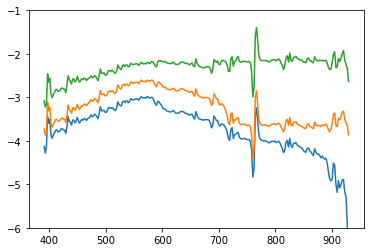

In [49]:
plt.plot(wl,sand_spec_log_q1)
plt.plot(wl,sand_spec_log_q2)
plt.plot(wl,sand_spec_log_q3)
plt.ylim(-6,-1)
plt.show()

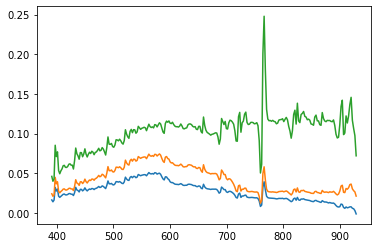

In [50]:
sand_spec = hyspec_tiles[annotation_tiles==1]
sand_spec_q1 = np.percentile(sand_spec,10,axis=0)
sand_spec_q2 = np.percentile(sand_spec,50,axis=0)
sand_spec_q3 = np.percentile(sand_spec,90,axis=0)
plt.plot(wl,sand_spec_q1)
plt.plot(wl,sand_spec_q2)
plt.plot(wl,sand_spec_q3)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


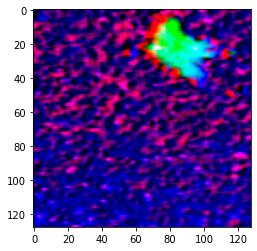

In [26]:
# Show example PCA tile (3 first components as RGB)
plt.imshow(image_render.percentile_stretch(pca_tiles[0,:,:,0:3]))
plt.show()

In [27]:
# Create the U-Net model
unet = hyspec_cnn.unet(input_channels=pca_tiles.shape[-1],
                       output_channels=len(class_dict)+1,
                       first_layer_channels=32,
                       depth = 4)
unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, None, None,  0           []                               
                                 10)]                                                             
                                                                                                  
 augmentation (Sequential)      (None, None, None,   0           ['input_image[0][0]']            
                                10)                                                               
                                                                                                  
 initial_convolution (Conv2D)   (None, None, None,   2912        ['augmentation[0][0]']           
                                32)                                                         

In [28]:
# Create tensorflow dataset, calculate class weights
n_labeled_pixels = np.count_nonzero(annotation_tiles!=0)
gamma = 0.8
class_weights = {0:0.1}
for class_name, class_index in class_dict.items():
    class_weights[class_index] = (n_labeled_pixels / np.count_nonzero(annotation_tiles==class_index))**gamma
print(class_weights)

{0: 0.1, 1: 2.1529073236778435, 2: 2.4850903217059495, 3: 4.394247481056919, 4: 20.657598875790473, 5: 6.452876590258547, 6: 23.89495425664711}


In [29]:
#sample_weights = np.array(annotation_tiles!=0,dtype=np.float32)  # All annotated pixels get weight 1, background 0
sample_weights = np.zeros_like(annotation_tiles,dtype=np.float32)
for class_ind in class_weights.keys():
    sample_weights[annotation_tiles==class_ind] = class_weights[class_ind]
dataset = tf.data.Dataset.from_tensor_slices((pca_tiles,annotation_tiles,sample_weights))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


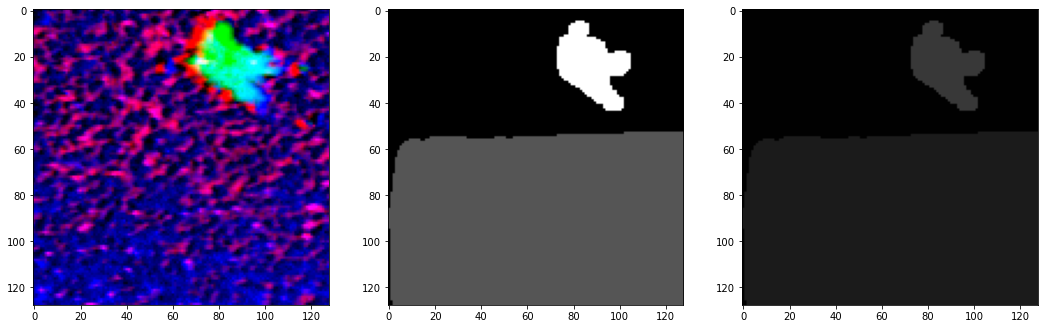

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


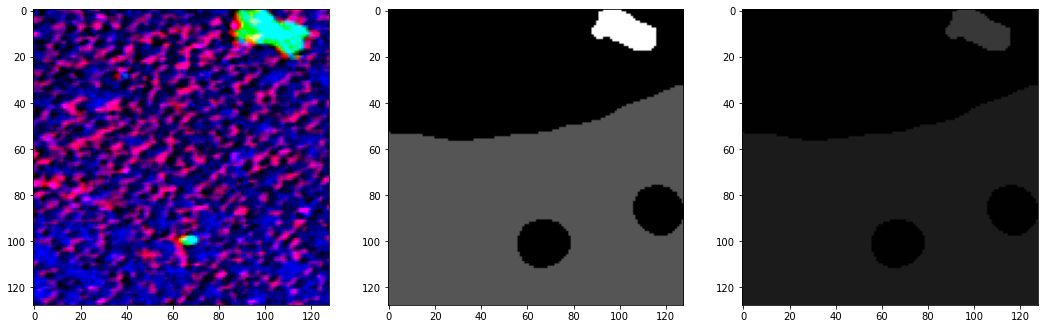

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


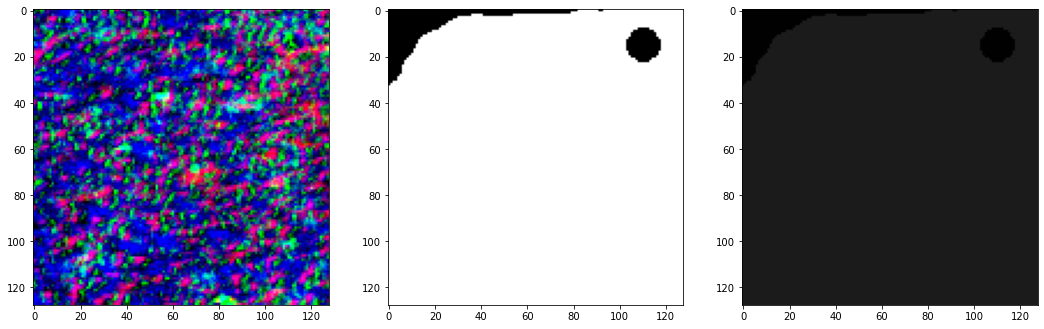

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


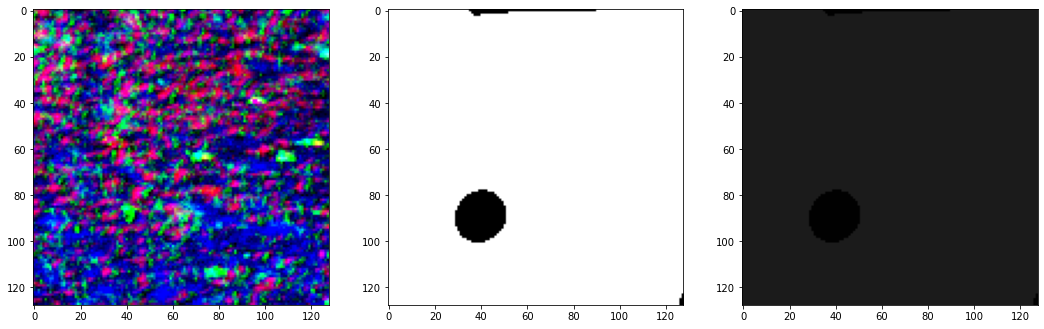

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


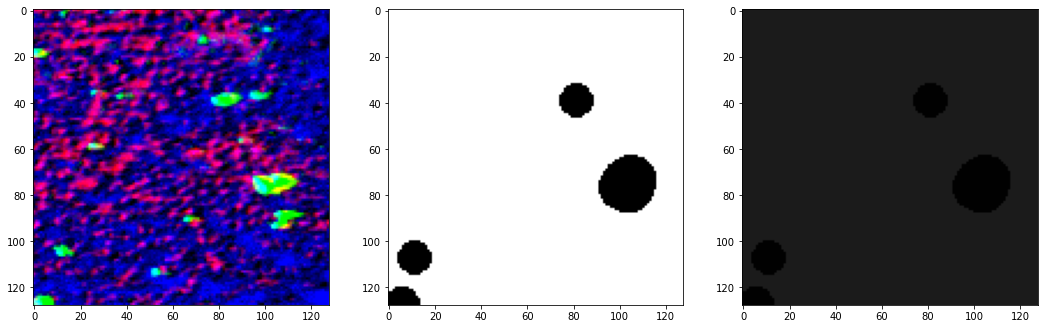

In [30]:
# Show some of the elements of the dataset
for image, mask, weights in dataset.take(5):    # Note: Must interate over dataset to "get" elements
    fig,ax = plt.subplots(1,3,figsize=(18,6))
    ax[0].imshow(image_render.percentile_stretch(np.array(image)[:,:,0:3]))
    ax[1].imshow(np.array(mask),cmap='gray')
    ax[2].imshow(np.array(weights),cmap='gray',vmin=0,vmax=20)
    plt.show()

In [31]:
# Split into training and validation datasets, create batches
n_val_tiles = int(TEST_FRAC*len(dataset))

dataset = dataset.shuffle(len(dataset))
val_dataset = dataset.take(n_val_tiles).batch(BATCH_SIZE)
train_dataset = dataset.skip(n_val_tiles).batch(BATCH_SIZE)

In [32]:
# Compile model. NOTE: Need smaller learning rate than standard RMSprop
unet.compile(optimizer=tf.keras.optimizers.RMSprop(0.00002), 
             loss="sparse_categorical_crossentropy",
             weighted_metrics=[])
#unet.compile(optimizer='adam', loss="sparse_categorical_crossentropy",weighted_metrics=[])
#unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy",weighted_metrics=[])


In [33]:
# Fit model to dataset
history = unet.fit(train_dataset,
                   epochs=50,
                   validation_data=val_dataset)


Epoch 1/50
23/23 [==============================] - 32s 1s/step - loss: 12.7239 - val_loss: 12.9500
Epoch 2/50
23/23 [==============================] - 25s 1s/step - loss: 10.0529 - val_loss: 9.7946
Epoch 3/50
23/23 [==============================] - 25s 1s/step - loss: 7.7224 - val_loss: 9.6730
Epoch 4/50
23/23 [==============================] - 24s 1s/step - loss: 7.0207 - val_loss: 6.4011
Epoch 5/50
23/23 [==============================] - 24s 1s/step - loss: 5.2655 - val_loss: 6.2665
Epoch 6/50
23/23 [==============================] - 24s 1s/step - loss: 4.4311 - val_loss: 5.5647
Epoch 7/50
23/23 [==============================] - 24s 1s/step - loss: 4.3153 - val_loss: 4.9822
Epoch 8/50
23/23 [==============================] - 24s 1s/step - loss: 3.5749 - val_loss: 4.3669
Epoch 9/50
23/23 [==============================] - 24s 1s/step - loss: 3.5761 - val_loss: 2.7650
Epoch 10/50
23/23 [==============================] - 24s 1s/step - loss: 3.3779 - val_loss: 3.5732
Epoch 11/50
23/2

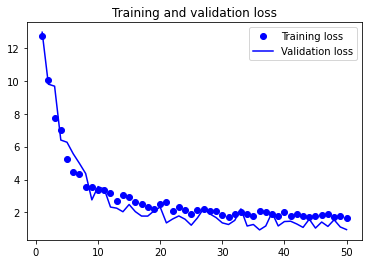

In [34]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [35]:
unet.save('unet_logpca_depth4_50epochs_weighted_classes')

INFO:tensorflow:Assets written to: unet_logpca_depth4_50epochs_weighted_classes/assets


INFO:tensorflow:Assets written to: unet_logpca_depth4_50epochs_weighted_classes/assets


1/1 [==============================] - 5s 5s/step


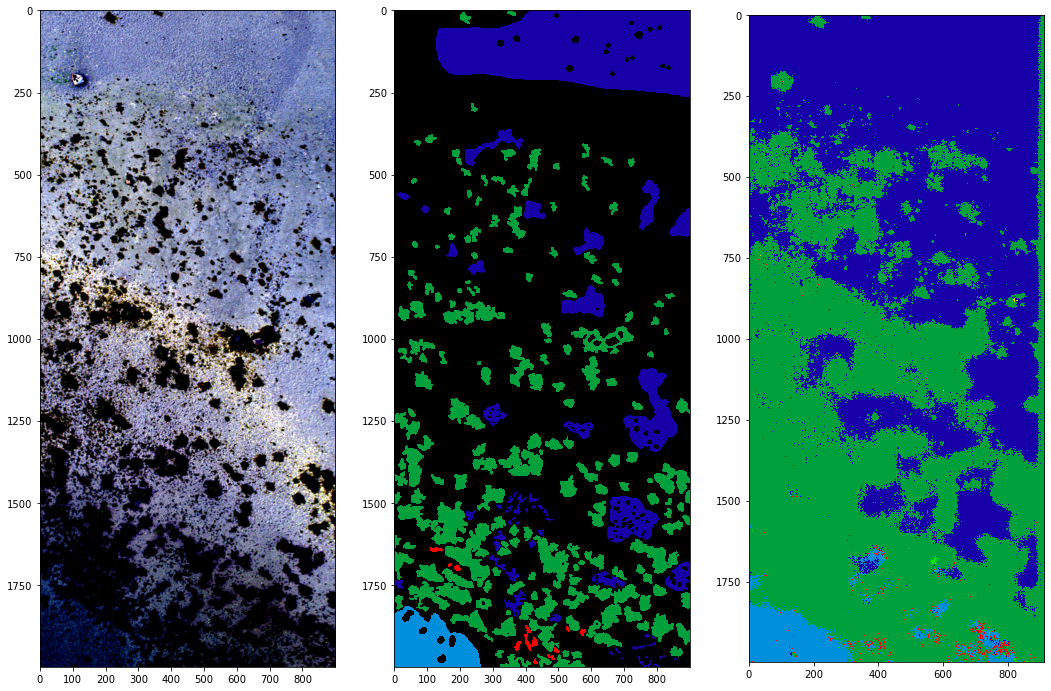

1/1 [==============================] - 4s 4s/step


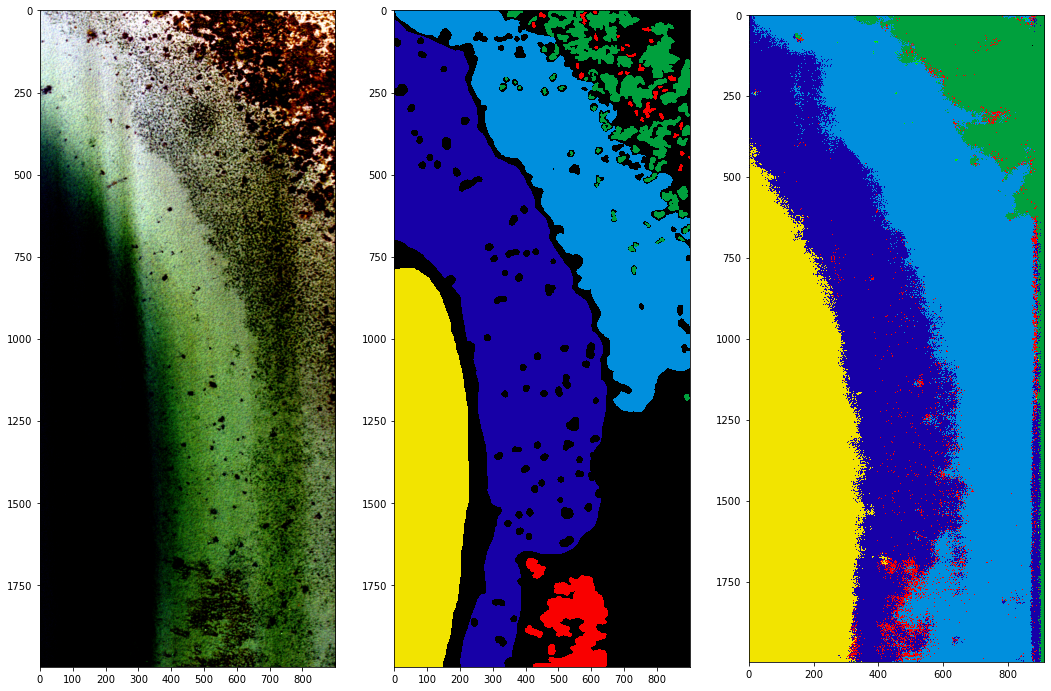

1/1 [==============================] - 3s 3s/step


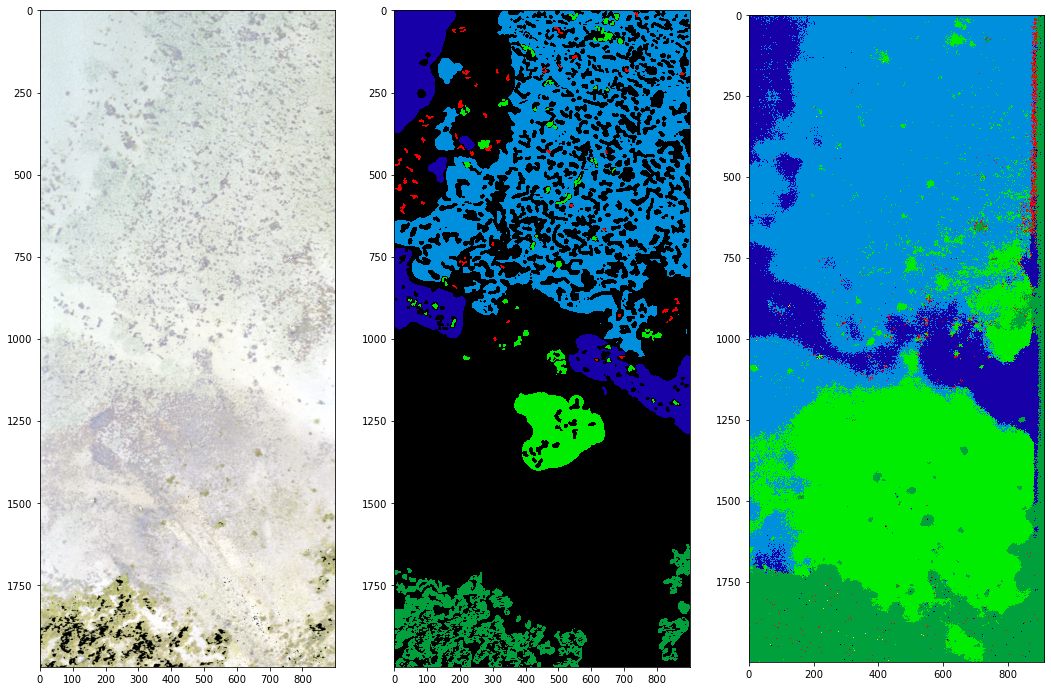

In [51]:
for annotation_file in ann_file_paths:
    # Load hyperspectral image
    hyspec_file = pathlib.Path(hyspec_dir) / (annotation_file.stem[:-3] + 'Crop Wavelengths.bip.hdr')
    hyspec_image, wl, rgb_ind, metadata = hyspec_io.load_envi_image(hyspec_file)

    # Load annotation image
    class_mask = skimage.io.imread(annotation_file)
    class_mask[np.all(hyspec_image==0,axis=2)] = 0        # Don't include zero data
        
    # Use model to predict classes
    hyspec_image[hyspec_image<0.0001] = 0.0001
    hyspec_image = np.log(hyspec_image)
    
    pca_image = pca.transform(np.reshape(hyspec_image,(-1,hyspec_image.shape[-1])))
    pca_image = np.reshape(pca_image,[*hyspec_image.shape[0:2],-1])
    pca_image = hyspec_cnn.pad_image_to_multiple(pca_image,16)
    segm_image = unet.predict(np.expand_dims(pca_image,axis=0))
    segm_image = np.argmax(segm_image.squeeze(),axis=2)
    
    fig,ax = plt.subplots(1,3,figsize=(18,18))
    ax[0].imshow(image_render.percentile_stretch(hyspec_image[:,:,rgb_ind],percentiles=(1,99)))
    ax[1].imshow(class_mask,vmin = 0, vmax = 7, cmap='nipy_spectral',interpolation='none')
    ax[2].imshow(segm_image,vmin = 0, vmax = 7, cmap='nipy_spectral',interpolation='none')
    plt.show()

1/1 [==============================] - 3s 3s/step


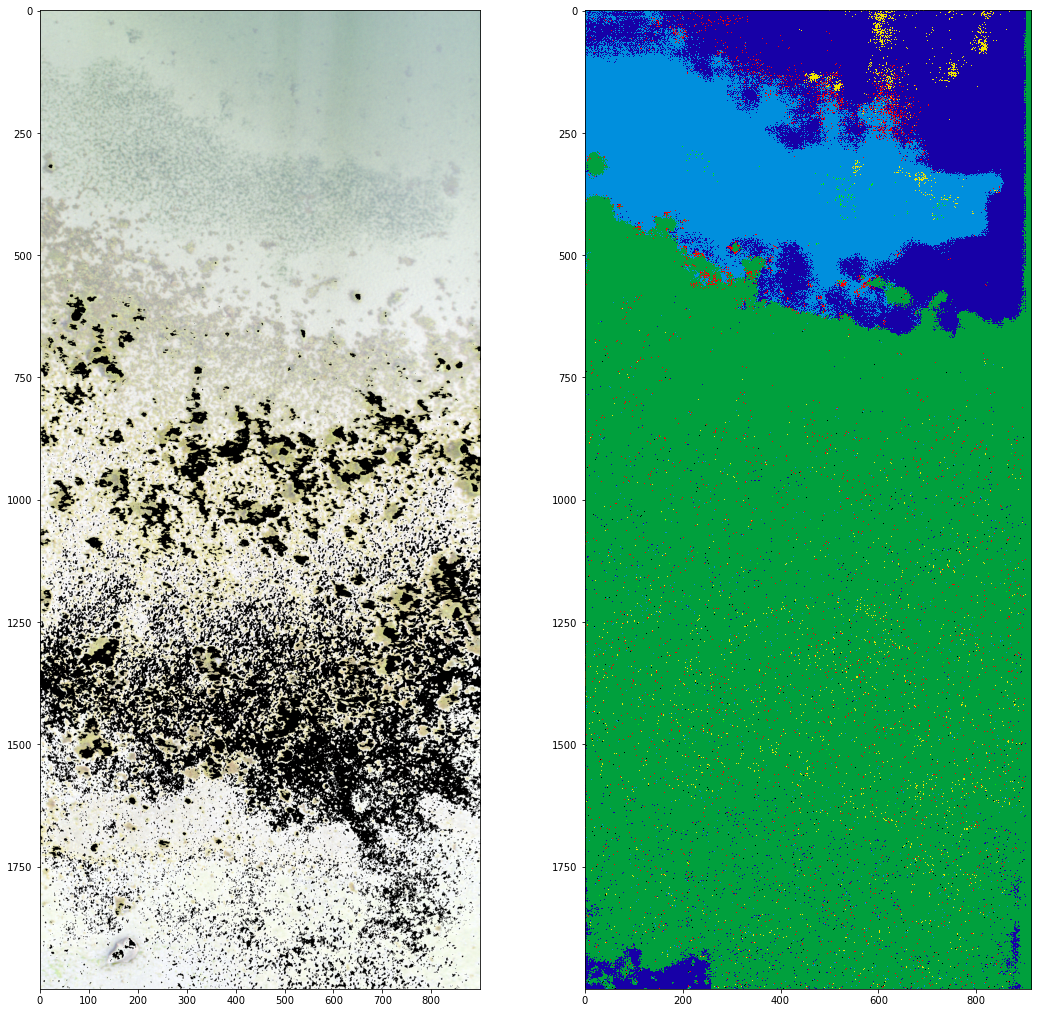

1/1 [==============================] - 3s 3s/step


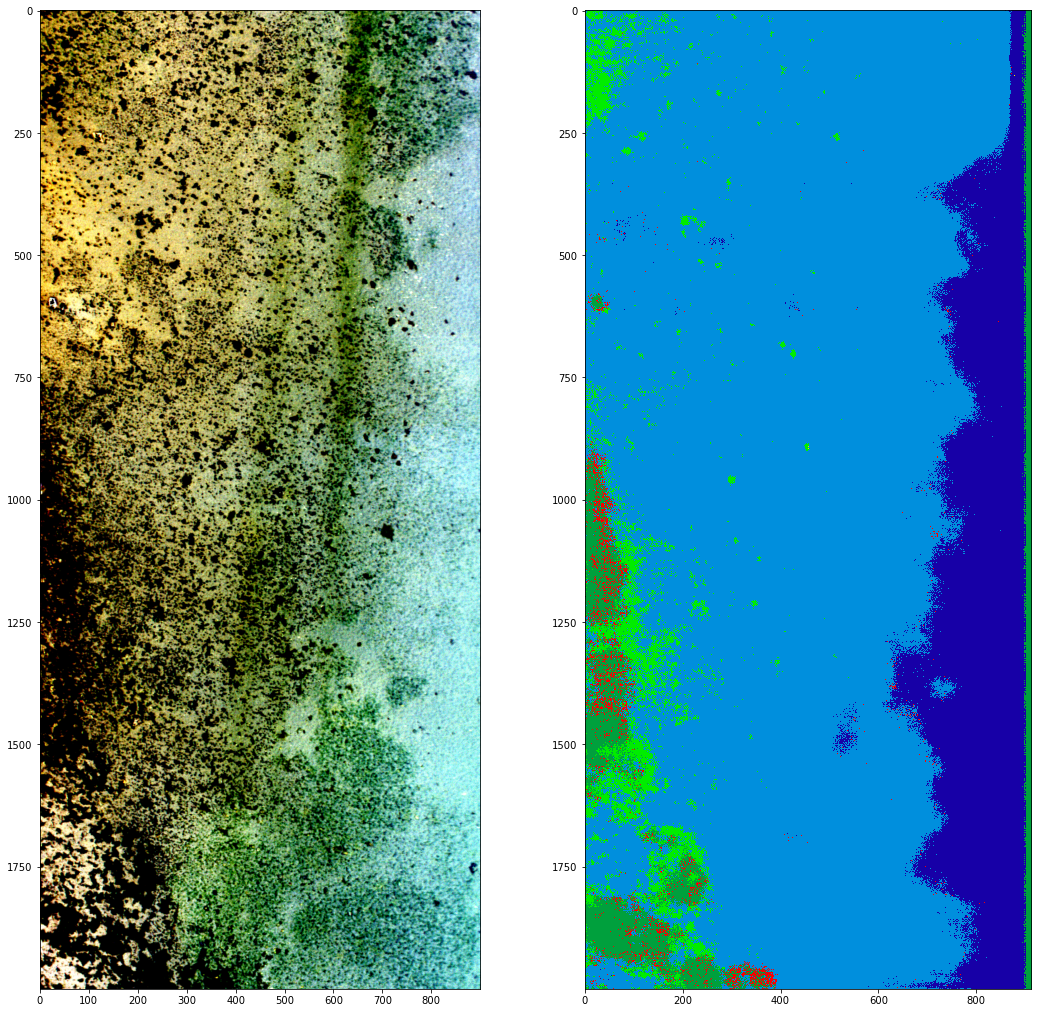

1/1 [==============================] - 3s 3s/step


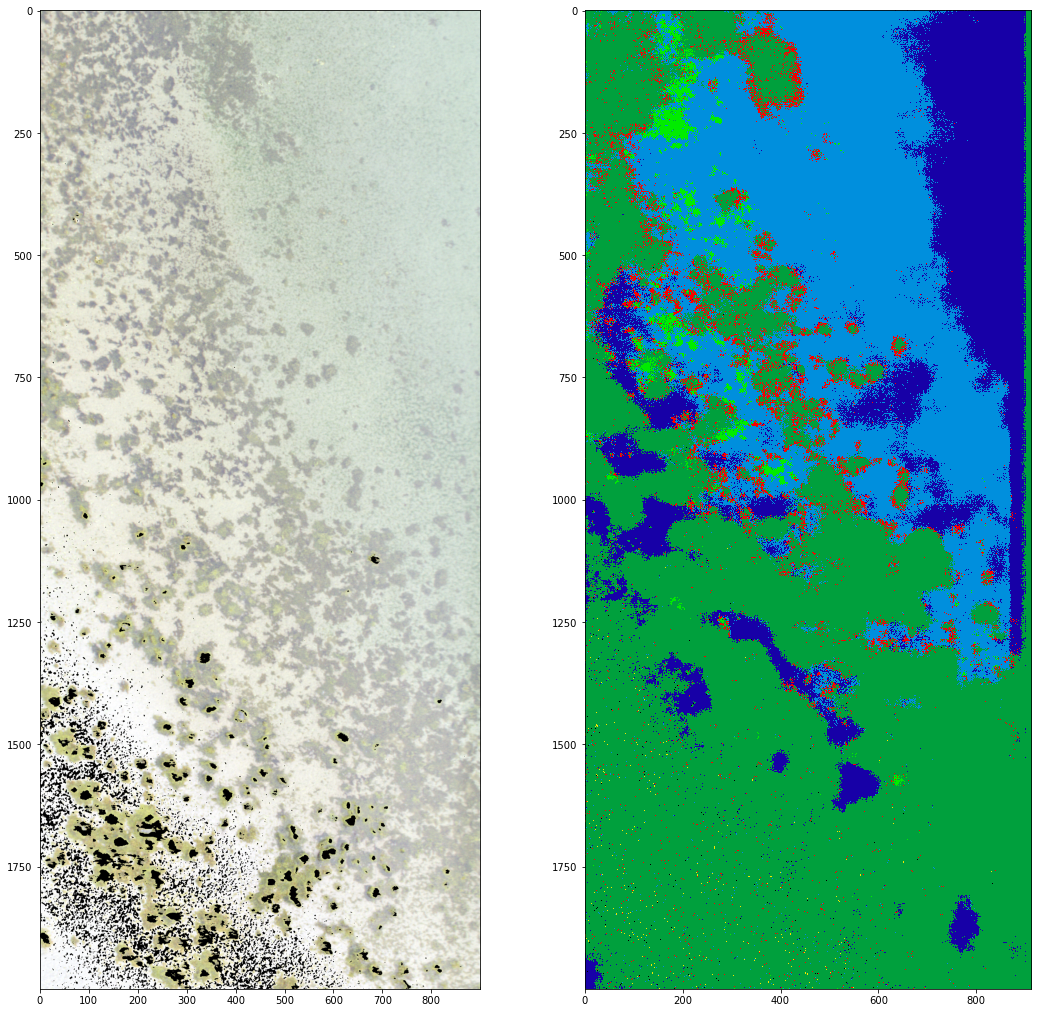

In [37]:
example_files = ['Juvika_June2022_Pika_L_10-Crop Wavelengths.bip.hdr',
                'Juvika_June2022_Pika_L_20-Crop Wavelengths.bip.hdr',
                'Juvika_June2022_Pika_L_21-Crop Wavelengths.bip.hdr']


# Try the model on some new (unanotated) images
for example_file in example_files:
    # Load hyperspectral image
    hyspec_file = pathlib.Path(hyspec_dir) / example_file
    hyspec_image, wl, rgb_ind, metadata = hyspec_io.load_envi_image(hyspec_file)
        
    # Log
    hyspec_image[hyspec_image<0.0001] = 0.0001
    hyspec_image = np.log(hyspec_image)

        
    # Use model to predict classes
    pca_image = pca.transform(np.reshape(hyspec_image,(-1,hyspec_image.shape[-1])))
    pca_image = np.reshape(pca_image,[*hyspec_image.shape[0:2],-1])
    pca_image = hyspec_cnn.pad_image_to_multiple(pca_image,16)
    segm_image_prob = unet.predict(np.expand_dims(pca_image,axis=0))
    segm_image = np.argmax(segm_image_prob.squeeze(),axis=2)
    
    fig,ax = plt.subplots(1,2,figsize=(18,18))
    ax[0].imshow(image_render.percentile_stretch(hyspec_image[:,:,rgb_ind]))
    ax[1].imshow(segm_image,vmin = 0, vmax = 7, cmap='nipy_spectral',interpolation='none')
    plt.show()